In [1]:
# import necessary packages

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot, figure
from pandas import read_csv, DataFrame, concat, to_datetime
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM



#Check for version and GPU support 
print("Version: ", tf.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  1.15.0
GPU is available


In [2]:
#Importing the dataset, removing unnecessary variables, filling all NA's with 0 for FEDFUNDS
df = read_csv('../data/ucsbdata.csv')
updated_dataset = df[['Index','OPEN', 'HIGH', 'LOW', 'CLOSE', 'PER', 'EPS', 'FEDFUNDS']]
updated_dataset['FEDFUNDS'].fillna(0, inplace=True)
# convert to datetime
updated_dataset['Index'] = to_datetime(df['Index'])
updated_dataset.info()
# set the index
df.set_index('Index', inplace=True)
df.info()
updated_dataset.to_csv('updated_ucsbdata.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16863 entries, 0 to 16862
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Index     16863 non-null  datetime64[ns]
 1   OPEN      16863 non-null  float64       
 2   HIGH      16863 non-null  float64       
 3   LOW       16863 non-null  float64       
 4   CLOSE     16863 non-null  float64       
 5   PER       16863 non-null  float64       
 6   EPS       16863 non-null  float64       
 7   FEDFUNDS  16863 non-null  float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 1.0 MB


/home/chilledapplesauce/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/pandas/core/generic.py:6244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/home/chilledapplesauce/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<class 'pandas.core.frame.DataFrame'>
Index: 16863 entries, 1952-01-02 to 2018-12-31
Data columns (total 67 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   R                 9826 non-null   float64
 1   US10YR            14348 non-null  float64
 2   EPS               16863 non-null  float64
 3   PER               16863 non-null  float64
 4   OPEN              16863 non-null  float64
 5   HIGH              16863 non-null  float64
 6   LOW               16863 non-null  float64
 7   CLOSE             16863 non-null  float64
 8   BDIY              8568 non-null   float64
 9   VIX               7307 non-null   float64
 10  PCR               5532 non-null   float64
 11  MVOLE             3774 non-null   float64
 12  DXY               12086 non-null  float64
 13  ASP               16863 non-null  float64
 14  ADVDECL           16863 non-null  float64
 15  FEDFUNDS          16237 non-null  float64
 16  NYSEADV           7202 non-null

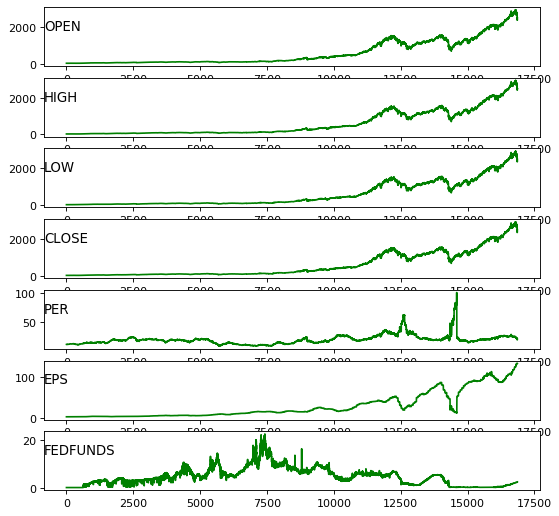

In [3]:
# Load dataset, specify variables to run plot function
dataset = read_csv('updated_ucsbdata.csv', header=0, index_col=0)
values = dataset.values
groups = [1, 2, 3, 4, 5, 6, 7]
i = 1
# Plot each column
pyplot.figure(num=None, figsize=(8, 8), dpi=80, facecolor='white', edgecolor='red')
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group], color = 'green')
    pyplot.title(dataset.columns[group], y=0.5, loc='left')
    i += 1
pyplot.show()

In [4]:
dataset.head()

,Index,OPEN,HIGH,LOW,CLOSE,PER,EPS,FEDFUNDS
0,1952-01-02,23.80,23.80,23.80,23.80,9.754098,2.44,0.0
1,1952-01-03,23.88,23.88,23.88,23.88,9.786885,2.44,0.0
2,1952-01-04,23.92,23.92,23.92,23.92,9.803279,2.44,0.0
3,1952-01-07,23.91,23.91,23.91,23.91,9.799180,2.44,0.0
4,1952-01-08,23.82,23.82,23.82,23.82,9.762295,2.44,0.0


In [5]:
# Convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# load dataset
dataset = read_csv('updated_ucsbdata.csv', header=0, index_col=1)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[6]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.000000   0.000374   0.000374   0.000375   0.003642   0.032609   
2   0.000059   0.000402   0.000401   0.000403   0.004151   0.032954   
3   0.000119   0.000415   0.000415   0.000417   0.004370   0.033127   
4   0.000178   0.000412   0.000411   0.000413   0.004297   0.033084   
5   0.000237   0.000381   0.000380   0.000382   0.003787   0.032695   

   var8(t-1)   var1(t)   var2(t)   var3(t)   var4(t)   var5(t)   var6(t)  \
1        0.0  0.000059  0.000402  0.000401  0.000403  0.004151  0.032954   
2        0.0  0.000119  0.000415  0.000415  0.000417  0.004370  0.033127   
3        0.0  0.000178  0.000412  0.000411  0.000413  0.004297  0.033084   
4        0.0  0.000237  0.000381  0.000380  0.000382  0.003787  0.032695   
5        0.0  0.000297  0.000353  0.000353  0.000355  0.003350  0.032350   

    var7(t)  var8(t)  
1  0.000766      0.0  
2  0.000766      0.0  
3  0.000766      0.0  
4  0.000766      0.0  
5

In [6]:
# split into train and test sets
values = reframed.values
n_train_days = 13491
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(13491, 1, 14) (13491,) (3371, 1, 14) (3371,)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 13491 samples, validate on 3371 samples
Epoch 1/100
13491/13491 - 3s - loss: 0.0734 - val_loss: 0.0557
Epoch 2/100
13491/13491 - 1s - loss: 0.0711 - val_loss: 0.0834
Epoch 3/100
13491/13491 - 1s - loss: 0.0557 - val_loss: 0.1482
Epoch 4/100
13491/13491 - 1s - loss: 0.0552 - val_loss: 0.1036
Epoch 5/100
13491/13491 - 1s - loss: 0.0393 - val_loss: 0.1528
Epoch 6/100
13491/13491 - 1s - loss: 0.0399 - val_loss: 0.1090
Epoch 7/100
13491/13491 - 1s - loss: 0.0357 - val_loss: 0.0891
Epoch 8/100
13491/13491 - 1s - loss: 0.0335 - val_loss: 0.0717
Epoch 9/100
13491/13491 - 1s - loss: 0.0324 - val_loss: 0.0659
Epoch 10/100
13491/13491 - 1s - loss: 0.0310 - val_loss: 0.0625
Epoch 11/100
13491/13491 - 1s - loss: 0.0289 - val_loss: 0.0601
Epoch 12/100
13491/13491 - 1s - loss: 0.0278 - val_loss: 0.0596
Epoch 13/100
1349

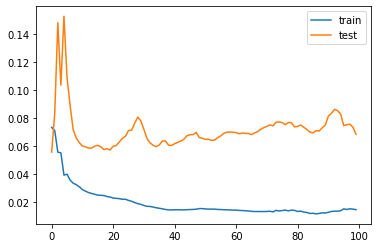

In [7]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [9]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

ValueError: Error when checking input: expected lstm_input to have 3 dimensions, but got array with shape (3371, 14)